# RAVIR-Challenge
RAVIR: A Dataset and Methodology for the Semantic Segmentation and Quantitative Analysis of Retinal Arteries and Veins in Infrared Reflectance Imaging Challenge.

## Introduction
This is an implementation to solve this challenge. This implementation is presented as a project for the subject DEEP LEARNING FOR MEDICAL IMAGE ANALYSIS (DLMIA) coursed in Universitat de Barcelona as a part of a Master Degree in Artificial Inteligence.

## Loading folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras import layers
from sklearn import metrics
from PIL import ImageOps
from scipy.spatial.distance import dice

C:\Users\mateo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare data

In [2]:
input_dir_train = "RAVIR_Dataset\\train\\training_images"
target_dir_train = "RAVIR_Dataset\\train\\training_masks"
input_dir_train_da = "RAVIR_Dataset_DA\\training_images"
target_dir_train_da = "RAVIR_Dataset_DA\\training_masks"
input_dir_test = ""
target_dir_test = ""
img_size = (256, 256)
def get_paths(input_dir, target_dir):
    input_img_paths = sorted(
      [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
      ]
    )
    target_img_paths = sorted(
      [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
      ]
    )
    return input_img_paths, target_img_paths

DATA_AUGMENTATION = True
VALIDATION = False
paths_train, paths_target = get_paths(input_dir_train, target_dir_train)
#paths_test , path_target_test = get_paths(input_dir_test, target_dir_test)
paths_train_da , paths_target_da = get_paths(input_dir_train_da, target_dir_train_da)
paths_train_val, paths_target_val = [],[]

if DATA_AUGMENTATION:
  paths_train += paths_train_da
  paths_target += paths_target_da
else:
  del paths_train_da, paths_target_da

if VALIDATION:
  split = int(len(paths_train)*0.8)
  paths_train_val = paths_train[split:]
  paths_train = paths_train[:split]
  paths_target_val = paths_target[split:]
  paths_target = paths_target[:split]

print("Total images:", len(paths_train))
print("Total target images:", len(paths_target))


Total images: 92
Total target images: 92


## Data Generator

In [3]:
class DataGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.array(img)
            img[img==255] = 2
            img[img==128] = 1
            y[j] = np.expand_dims(img, 2)
        return x, y

## Model

Models used for this challenge

### Unet

In [4]:
def unet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

## GENERATORS AND CONSTANTS TO TRAIN


In [8]:
BATCHSIZE = 8
EPOCHS = 30
IMAGE_SIZE = (512,512)
lr = 0.001
optimizerA = keras.optimizers.Adam(learning_rate=lr)
optimizerRMSPROP = keras.optimizers.RMSprop(learning_rate=lr)


train_generator = DataGenerator(BATCHSIZE, IMAGE_SIZE, paths_train, paths_target)


## Training

In [15]:
model = unet(IMAGE_SIZE, num_classes=3)

In [16]:
model.compile(optimizer=optimizerA, loss="sparse_categorical_crossentropy", metrics=["accuracy" ])
callbacks = [
    keras.callbacks.ModelCheckpoint("ravir_challenge.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto', restore_best_weights=True)
]
if VALIDATION:
    val_generator = DataGenerator(BATCHSIZE, IMAGE_SIZE, paths_train_val, paths_target_val)
    mdl_hist = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks)
else:
    mdl_hist = model.fit(train_generator, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30
11/11 [==============================] - 178s 15s/step - loss: 3.0837 - accuracy: 0.8748
Epoch 2/30
11/11 [==============================] - 141s 13s/step - loss: 0.6256 - accuracy: 0.9390
Epoch 3/30
11/11 [==============================] - 137s 12s/step - loss: 0.4660 - accuracy: 0.9572
Epoch 4/30
11/11 [==============================] - 138s 12s/step - loss: 0.4271 - accuracy: 0.9675
Epoch 5/30
11/11 [==============================] - 136s 12s/step - loss: 0.4041 - accuracy: 0.9683
Epoch 6/30
11/11 [==============================] - 138s 12s/step - loss: 0.3903 - accuracy: 0.9649
Epoch 7/30
11/11 [==============================] - 137s 12s/step - loss: 0.3806 - accuracy: 0.9623
Epoch 8/30
11/11 [==============================] - 136s 12s/step - loss: 0.3735 - accuracy: 0.9576
Epoch 9/30
11/11 [==============================] - 137s 12s/step - loss: 0.3648 - accuracy: 0.9564
Epoch 10/30
11/11 [==============================] - 137s 12s/step - loss: 0.3596 - accuracy: 0.9572

## Plotting results of training

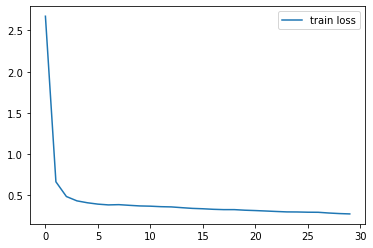

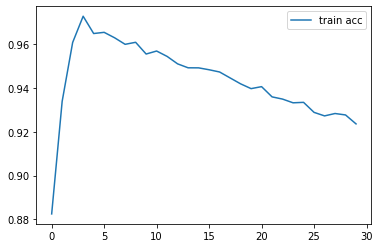

In [ ]:
plt.plot(mdl_hist.history['loss'], label='train loss')
if VALIDATION:
    plt.plot(mdl_hist.history['val_loss'], label='val loss')
plt.legend()
plt.savefig(model_name + "_data_epochs_" + str(EPOCHS) + "_batchSize_"+ str(BATCHSIZE) + '_LossVal_loss')
plt.show()
# plot the accuracy
plt.plot(mdl_hist.history['accuracy'], label='train acc')
if VALIDATION:
    plt.plot(mdl_hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig(model_name + "_data_epochs_" +str(EPOCHS)+"_batchSize_"+ str(BATCHSIZE)+'_AccVal_acc')
#save model to disk
plt.show()

## Testing

In [11]:
model.compile(optimizer=optimizerA, loss="sparse_categorical_crossentropy", metrics=["accuracy" ])
model.load_weights('ravir_challenge_bo_da.h5')

11/11 [==============================] - 44s 4s/step - loss: 0.3843 - accuracy: 0.9517
test loss, test acc: [0.384327232837677, 0.9517444968223572]
11/11 [==============================] - 42s 4s/step


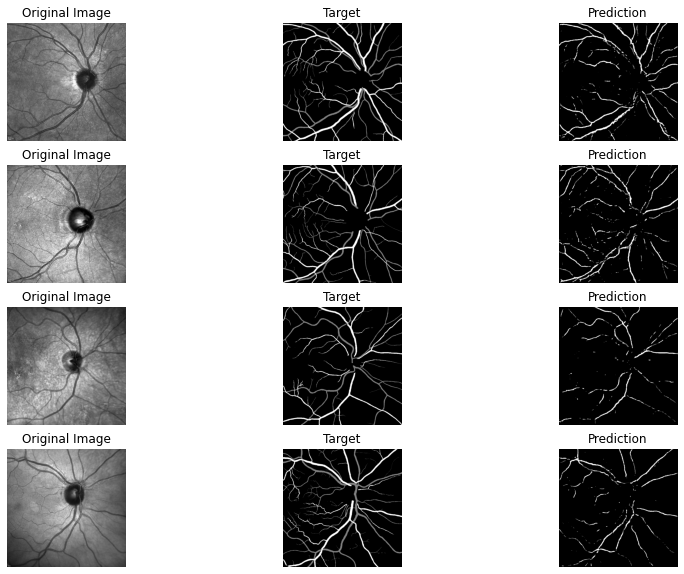

In [12]:

results = model.evaluate(train_generator, batch_size=8)
print("test loss, test acc:", results)
val_preds = model.predict(train_generator)

def mask_to_image(preds, i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = keras.preprocessing.image.array_to_img(mask)
    return img


import numpy.ma as ma

# Display results for validation image #10
inds = [0,2,4,8]

# Create figure and plot
fig = plt.figure(figsize=(14, 10))

nrows = len(inds)
ncols = 3

for row, i in enumerate(inds):
    base_ind = row*ncols

    # Add the original image subplot at the 1st position
    fig.add_subplot(nrows, ncols, base_ind+1)
    image = plt.imread(paths_train[i])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")

    # Add the original target subplot at the 2nd position
    fig.add_subplot(nrows, ncols, base_ind+2)
    target = plt.imread(paths_target[i])
    plt.imshow(target, cmap="gray")
    plt.axis('off')
    plt.title("Target")

    # Add the predicted target subplot at the 3rd position
    fig.add_subplot(nrows, ncols, base_ind+3)
    pred = mask_to_image(val_preds, i)
    plt.imshow(pred, cmap="gray")
    plt.axis('off')
    plt.title("Prediction")

plt.show()